# 预训练模型

In [61]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import json
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 数据准备

In [73]:
# 加载图像并生成批次数据
def generator(data_path, label_path, batch_size):
    """
    读取图像，并生成批次数据

    参数说明
    ----------
    data_path : {str}
        图像文件夹地址
    batch_size : {int} 
        输入数据的批次大小，正整数
    label_path : {str} 
        标签字典保存地址

    返回值
    -------
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[批次，目标，特征时间编码，目标时间编码]
    """
    # 定义图像变换操作
    transform = transforms.Compose([
        transforms.Resize((224, 224)),         # 调整图像大小
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
        transforms.ToTensor(),                  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    print(f"图像个数：{len(dataset)}, 尺寸：{dataset[0][0].shape}")

    # 获取类别名称和索引
    class_to_idx = dataset.class_to_idx  # 字典形式：类别名称 -> 索引
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # 反向字典：索引 -> 类别名称
    with open(os.path.join(label_path + '/idx_to_class.json'), 'w') as f:
        json.dump(idx_to_class, f)
    
    # 数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 查看一个批次数据
    images, labels = next(iter(dataloader))
    print(f"图像批次大小: {images.shape}")
    print(f"标签批次大小: {labels.shape}")
    print(f"图像批次个数: {len(dataloader)}")

    return dataloader

In [74]:
# 训练集
params1 = {
    "data_path": "../data/cats_and_dogs_small/train",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("训练集：")
train_loader = generator(**params1)

# 验证集
params2 = {
    "data_path": "../data/cats_and_dogs_small/validation",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("验证集：")
valid_loader = generator(**params2)

# 测试集
params3 = {
    "data_path": "../data/cats_and_dogs_small/test",
    "label_path": "../outputs/labels",
    "batch_size": 32,
}
print("测试集：")
test_loader = generator(**params3)

训练集：
图像个数：2000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 63
验证集：
图像个数：1000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 32
测试集：
图像个数：1000, 尺寸：torch.Size([3, 224, 224])
图像批次大小: torch.Size([32, 3, 224, 224])
标签批次大小: torch.Size([32])
图像批次个数: 32


## 加载预训练模型

pre-trained model

### VGG16

VGG16 的网络结构主要分为两部分：

- 特征提取部分（features）：由多个卷积层和池化层组成，提取输入图像的特征。
- 分类器部分（classifier）：全连接层组成，用于将提取的特征映射到具体的类别。

对于 torchvision.models.vgg16 的分类器部分，结构如下：

In [80]:
# 加载预训练的 VGG16 模型
VGG16 = models.vgg16(pretrained=True)

In [81]:
# 冻结卷积层参数
for param in VGG16.features.parameters():
    param.requires_grad = False

# 修改分类头
num_classes = 2
VGG16.classifier[6] = nn.Linear(VGG16.classifier[6].in_features, num_classes)

In [82]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### ResNet50

ResNet50 是 ResNet（Residual Network）系列中的一种深度神经网络，其主要特点是引入了 残差连接（Residual Connection），解决了深度网络中梯度消失和训练困难的问题。ResNet50 共有 50 层（包括卷积层和全连接层），其设计理念是通过跳跃连接（skip connections）让网络更容易训练，从而获得更好的性能。

ResNet50 是 ResNet 系列中比较常用的版本，广泛应用于图像分类、目标检测、语义分割等任务。

ResNet50 的结构可以分为以下几部分：

- Initial Convolutional Layer  
一个 
7×7 卷积层，步幅为 2，负责提取图像的低级特征，并将输入图像尺寸减小。

- MaxPooling Layer  
接着是一个 
3×3 的最大池化层，步幅为 2。


- Residual Blocks  
之后是多个 残差块，每个残差块内部包含多个卷积层，并且每两个卷积层之间有跳跃连接（skip connections）。通过跳跃连接，网络能够避免梯度消失问题，尤其是在很深的网络中。  
在 ResNet50 中，残差块采用了 瓶颈结构，即每个残差块包含三个卷积层（1x1、3x3、1x1）：  
第一个卷积层：  
1×1 卷积，减少通道数。  
第二个卷积层：  
3×3 卷积，进行特征提取。  
第三个卷积层：  
1×1 卷积，恢复通道数。


- Global Average Pooling  
在所有残差块之后，使用 全局平均池化（Global Average Pooling）层，将每个通道的特征图压缩成一个标量，进一步降低了参数数量，减少过拟合。


- Fully Connected Layer  
最后，通过一个全连接层（FC Layer）进行分类，输出类别的数量。

In [23]:
# # 加载预训练的 ResNet 模型
ResNet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\caoyuyu/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:07<00:00, 1.52MB/s]


In [26]:
# 冻结部分层
for name, param in ResNet50.named_parameters():
    if name.startswith('layer1') or name.startswith('layer2'):  # 冻结 layer1 和 layer2
        param.requires_grad = False
        
# 修改分类头
num_classes = 2
ResNet50.fc = nn.Linear(ResNet50.fc.in_features, num_classes)  # 修改分类头

### GoogLeNet

GoogLeNet 的深度为 22 层（包括卷积层和全连接层），但其参数量比 AlexNet 少了 12 倍，大约是 6.8M。它的主要设计目标是提升网络深度的同时，避免参数数量过多的问题。

GoogLeNet 结构由以下部分组成：

- Initial Layers（初始层）  
通过基本的卷积层和最大池化层提取初始特征。

- Inception 模块  
GoogLeNet 的核心创新模块，包含并行的卷积和池化操作，可以捕获多尺度特征。


- Global Average Pooling（全局平均池化）  
代替全连接层，大大减少了参数量，同时降低了过拟合风险。


- Auxiliary Classifiers（辅助分类器）  
在中间层引入两个辅助分类器，用于缓解梯度消失问题，同时提高训练效果。

In [27]:
# 加载预训练的 GoogLeNet 模型
GoogLeNet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\caoyuyu/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:30<00:00, 1.69MB/s]


In [28]:
# 修改分类层以适应新任务
num_classes = 2  # 自定义任务的类别数
GoogLeNet.fc = nn.Linear(GoogLeNet.fc.in_features, num_classes)

### ConvNext

结合 CNN 和 Transformer 优势，适合复杂分类任务。

ConvNext  
特点：  
- 受 Transformer 设计启发，优化了传统 CNN 的架构。
- 提供 S、M、L 等版本。
  
适用场景：  
- 高性能分类任务。

In [29]:
# 加载预训练的 ConvNext 模型
ConvNext = models.convnext_base(pretrained=True)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to C:\Users\caoyuyu/.cache\torch\hub\checkpoints\convnext_base-6075fbad.pth
100%|███████████████████████████████████████████████████████████████████████████████| 338M/338M [03:35<00:00, 1.65MB/s]


In [30]:
# 冻结卷积层参数
for param in ConvNext.features.parameters():
    param.requires_grad = False

# 修改分类头
num_classes = 2
ConvNext.classifier[2] = nn.Linear(ConvNext.classifier[2].in_features, num_classes)

## 模型训练

In [83]:
def train(train_args):
    # 参数配置
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name.to(device)
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        train_correct_predictions = 0
        for batch_x, batch_y in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
            # 计算准确率
            _, preds = torch.max(outputs, dim=1)
            train_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)

        # 计算准确率
        train_accuracy = train_correct_predictions.double() / len(train_loader.dataset)
        
        #评估模型
        model.eval()
        preds = []
        trues = []
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            val_correct_predictions = 0
            for batch_x, batch_y in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) 
                batch_y = batch_y.to(device) 
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
                val_correct_predictions += torch.sum(preds == batch_y)
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)

        # 计算准确率
        val_accuracy = val_correct_predictions.double() / len(valid_loader.dataset)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.0261, Training Accuracy: 0.9915, Validation Loss: 0.1152, Validation Accuracy: 0.9780
Validation loss decreased (inf --> 0.115241).  Saving model ...


  2%|█▌                                                                            | 1/50 [17:34<14:20:53, 1054.16s/it]

Updating learning rate to 0.0009990133642141358


  4%|███                                                                           | 2/50 [35:32<14:14:56, 1068.67s/it]

Epoch [2/50], Training Loss: 0.0705, Training Accuracy: 0.9860, Validation Loss: 0.4402, Validation Accuracy: 0.9380
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.000996057350657239
Epoch [3/50], Training Loss: 0.2024, Training Accuracy: 0.9715, Validation Loss: 0.1071, Validation Accuracy: 0.9800
Validation loss decreased (0.115241 --> 0.107115).  Saving model ...


  6%|████▋                                                                         | 3/50 [53:26<13:58:48, 1070.82s/it]

Updating learning rate to 0.0009911436253643444


  8%|██████                                                                      | 4/50 [1:10:59<13:35:42, 1063.98s/it]

Epoch [4/50], Training Loss: 0.0834, Training Accuracy: 0.9875, Validation Loss: 0.3649, Validation Accuracy: 0.9730
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009842915805643156


 10%|███████▌                                                                    | 5/50 [1:28:37<13:16:11, 1061.58s/it]

Epoch [5/50], Training Loss: 0.2365, Training Accuracy: 0.9800, Validation Loss: 0.4159, Validation Accuracy: 0.9780
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0009755282581475768


 12%|█████████                                                                   | 6/50 [1:46:22<12:59:23, 1062.81s/it]

Epoch [6/50], Training Loss: 0.1644, Training Accuracy: 0.9870, Validation Loss: 0.4357, Validation Accuracy: 0.9710
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0009648882429441257


 14%|██████████▋                                                                 | 7/50 [2:04:06<12:41:56, 1063.17s/it]

Epoch [7/50], Training Loss: 0.1058, Training Accuracy: 0.9920, Validation Loss: 0.5787, Validation Accuracy: 0.9690
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0009524135262330098


 14%|██████████▋                                                                 | 7/50 [2:21:53<14:31:37, 1216.22s/it]

Epoch [8/50], Training Loss: 0.2816, Training Accuracy: 0.9880, Validation Loss: 1.4166, Validation Accuracy: 0.9630
EarlyStopping counter: 5 out of 5
Early stopping!


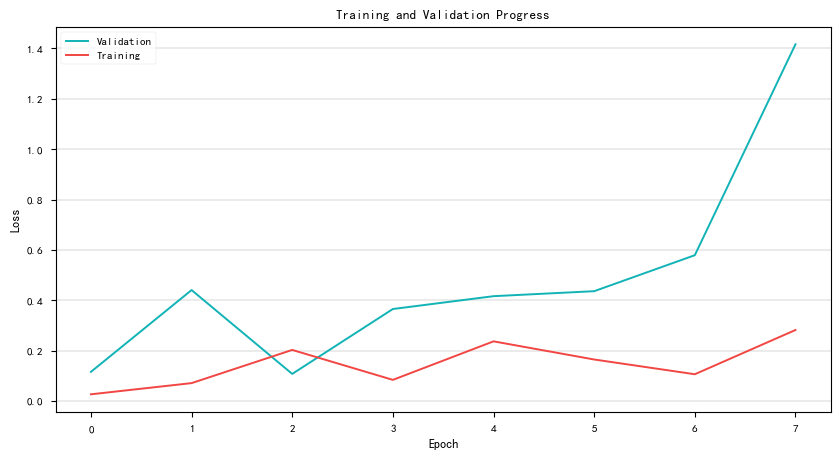

In [90]:
# 构造参数字典
params4 = {
    "train_args": {
        "model_name": VGG16,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/VGG16_C",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
}
model = train(**params4)

## 模型预测

In [87]:
def predict(predict_args):
    # 参数配置
    pre_model_name = predict_args['pre_model_name']
    data_path = predict_args['data_path']
    model_path = predict_args['model_path']
    device = predict_args['device']  # 可选'cuda'和'cpu'
    label_path = predict_args['label_path'] # 标签字典

    # 检查可用device
    device = torch.device(device)

    # 标签地址
    with open(os.path.join(label_path + '/idx_to_class.json'), 'r') as f:
        label_dicts = json.load(f)

    # 加载模型
    model = pre_model_name
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # 构造数据集
    transform = transforms.Compose([
        transforms.Resize((224, 224)),         # 调整图像大小
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 颜色抖动
        transforms.ToTensor(),                  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])

    # 加载待预测数据
    labels = {}
    for file_name in os.listdir(data_path):
        # 检查文件是否为 .jpg 格式
        if file_name.endswith(".jpg"):
            file_path = os.path.join(data_path, file_name)  # 获取完整路径
            image = Image.open(file_path).convert('RGB')  # 确保是 RGB 图像
            X_true = transform(image).unsqueeze(0)  # 添加 batch 维度
            X_true = X_true.to(device)  # 移动到设备（CPU 或 GPU）
        
            # 模型预测
            model.eval()
            with torch.no_grad():
                X_true = X_true.to(device)
                outputs = model(X_true)
                # 计算准确率
                _, preds = torch.max(outputs, dim=1)
            labels[file_name] = label_dicts[str(preds.item())]
        else:
            pass

    return labels

In [88]:
# 构造参数字典
params6 = {
    "predict_args": {
        "pre_model_name": VGG16,
        "model_path": "../outputs/best_models/VGG16_C/checkpoint.pth",
        "data_path": "../data/cats_and_dogs_small/test/cats",
        "device": 'cpu', 
        "label_path": "../outputs/labels"
    },
}
y_pred = predict(**params6)

In [89]:
y_pred

{'cat.1500.jpg': 'cats',
 'cat.1501.jpg': 'cats',
 'cat.1502.jpg': 'cats',
 'cat.1503.jpg': 'cats',
 'cat.1504.jpg': 'cats',
 'cat.1505.jpg': 'cats',
 'cat.1506.jpg': 'cats',
 'cat.1507.jpg': 'dogs',
 'cat.1508.jpg': 'cats',
 'cat.1509.jpg': 'cats',
 'cat.1510.jpg': 'cats',
 'cat.1511.jpg': 'cats',
 'cat.1512.jpg': 'cats',
 'cat.1513.jpg': 'cats',
 'cat.1514.jpg': 'cats',
 'cat.1515.jpg': 'cats',
 'cat.1516.jpg': 'cats',
 'cat.1517.jpg': 'cats',
 'cat.1518.jpg': 'cats',
 'cat.1519.jpg': 'cats',
 'cat.1520.jpg': 'cats',
 'cat.1521.jpg': 'cats',
 'cat.1522.jpg': 'cats',
 'cat.1523.jpg': 'cats',
 'cat.1524.jpg': 'cats',
 'cat.1525.jpg': 'cats',
 'cat.1526.jpg': 'cats',
 'cat.1527.jpg': 'cats',
 'cat.1528.jpg': 'cats',
 'cat.1529.jpg': 'cats',
 'cat.1530.jpg': 'cats',
 'cat.1531.jpg': 'cats',
 'cat.1532.jpg': 'cats',
 'cat.1533.jpg': 'cats',
 'cat.1534.jpg': 'cats',
 'cat.1535.jpg': 'cats',
 'cat.1536.jpg': 'cats',
 'cat.1537.jpg': 'cats',
 'cat.1538.jpg': 'cats',
 'cat.1539.jpg': 'cats',
